<a href="https://colab.research.google.com/github/sedaoturak/Quantum_Espresso_Colab/blob/main/Quantum_Espresso_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install the Quantum Espresso Binary

In [ ]:
%%capture
# Clone the QE git
!git clone https://github.com/QEF/q-e.git
# Install the dependencies
!apt-get install -y libfftw3-3 libfftw3-dev libfftw3-doc
# enter the q-e folder
%cd q-e
# run the configure file
!DFLAGS='-D__OPENMP -D__FFTW3 -D__MPI -D__SCALAPACK' FFT_LIBS='-lfftw3'  ./configure --enable-openmp
# computation time ~1 minute

Run the cell to make `pw.x` binary
If you need to make any other binary like `dos.x` or `bands.x`. Replace the `pw` with `dos` or `bands`

In [ ]:
%%capture 
!make pw #computation time ~5-7 minutes

Create a folder named "Quantum Files" to download and keep all the files needed including the input files and pseudopotential files

In [ ]:
# Navigating into your folder.
%cd /content/Quantum_Files/ 

/content/Quantum_Files


# Run the DFT code

Note: Check the directories for pseudopotential file and output file!

In [ ]:
! /content/q-e/bin/pw.x  -in si.scf.in > si.scf.out

# See the output file

In [ ]:
!cat si.scf.out


     Program PWSCF v.7.2 starts on  3Jun2023 at 15:50:55 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Parallel version (MPI & OpenMP), running on       2 processor cores
     Number of MPI processes:                 1
     Threads/MPI process:                     2

     MPI processes distributed on     1 nodes
     6652 MiB available memory on the printing compute node when the environment starts

     Reading input from si.scf.in

     Current dimensions of program PWSCF are:
     Max number of different atomic species (nty

In [ ]:
f = open("/content/Quantum_Files/si.scf.out", "r")
for l in f.readlines():
  if 'total energy' in l:
    print(l)

     total energy              =     -15.83067980 Ry

     total energy              =     -15.83241614 Ry

     total energy              =     -15.83269969 Ry

!    total energy              =     -15.83273079 Ry

     The total energy is the sum of the following terms:



In [ ]:
!grep -e "total energy" -e estimate si.scf.out

     total energy              =     -15.83067980 Ry
     estimated scf accuracy    <       0.04701189 Ry
     total energy              =     -15.83241614 Ry
     estimated scf accuracy    <       0.00213687 Ry
     total energy              =     -15.83269969 Ry
     estimated scf accuracy    <       0.00004693 Ry
!    total energy              =     -15.83273079 Ry
     estimated scf accuracy    <       0.00000002 Ry
     The total energy is the sum of the following terms:


In [ ]:
total_energies = []
f = open("/content/Quantum_Files/si.scf.out", "r")
for l in f.readlines():
  if 'total energy' in l:

    for i in l.split():
        try:
            #trying to convert i to float
            result = float(i)
            #break the loop if i is the first string that's successfully converted
            break
        except:
            continue
    total_energies.append(result)        

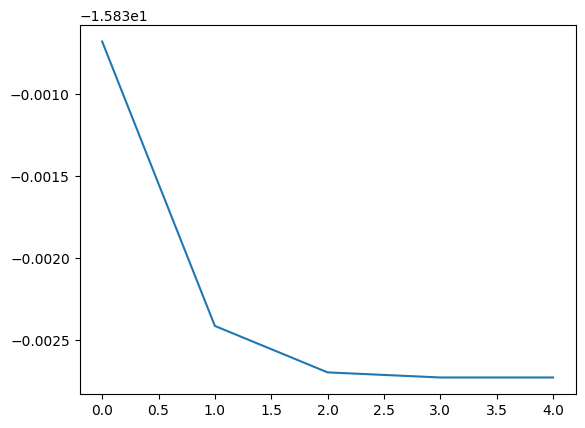

In [ ]:
import matplotlib.pyplot as plt

plt.plot(total_energies)

In [ ]:
f = open("/content/Quantum_Files/si.scf.in", "r")
for l in f.readlines():
  if 'ecutwfc' in l:
    for i in l.split():
        try:
            #trying to convert i to float
            result = float(i)
            #break the loop if i is the first string that's successfully converted
            break
        except:
            continue
    print(result)

-15.83273079
